In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from skimage.transform import resize

In [3]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    # todo
    
    print('Load file {} ...'.format(filename))
    dcm = pydicom.dcmread(filename)       
    img = dcm.pixel_array
    
    
    # Body Part
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Body part: {body_part}')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position: {pos}')
        return None
    
    # Modali
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'Image {filename} rejected, Modality: {mod}')
        return None
    
    findings = dcm.StudyDescription
    print('Findings:', findings)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_size): 
    normalized_img  = img / 255
    resized_img = resize(img, (img_size[1], img_size[2]))
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    
    with open(model_path, 'r') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json)
        model.load_weights(weight_path)    
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred_im = model.predict(img)   
    if pred_im > thresh:
        return 'Pneumonia'
    else:
        return 'Not Pneumonia'


Load file test1.dcm ...
Findings: No Finding


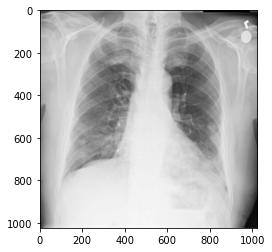

Not Pneumonia
Load file test2.dcm ...
Findings: Cardiomegaly


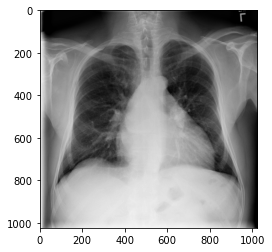

Not Pneumonia
Load file test3.dcm ...
Findings: Effusion


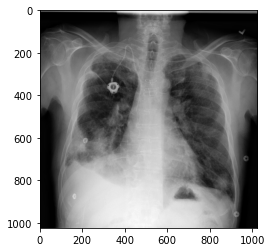

Not Pneumonia
Load file test4.dcm ...
Image test4.dcm rejected, Body part: RIBCAGE
Load file test5.dcm ...
Image test5.dcm rejected, Modality: CT
Load file test6.dcm ...
Image test6.dcm rejected, Patient position: XX


In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "my_model.json"
weight_path = "{}_my_model.best.hdf5".format('xray_class')


IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path)
thresh = 0.51 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)